# <center>Stock Price Analysis (AAPL - Apple Inc.) </center> 
#  <center> Time Series Forecasting with SARIMA and Prophet</center> 
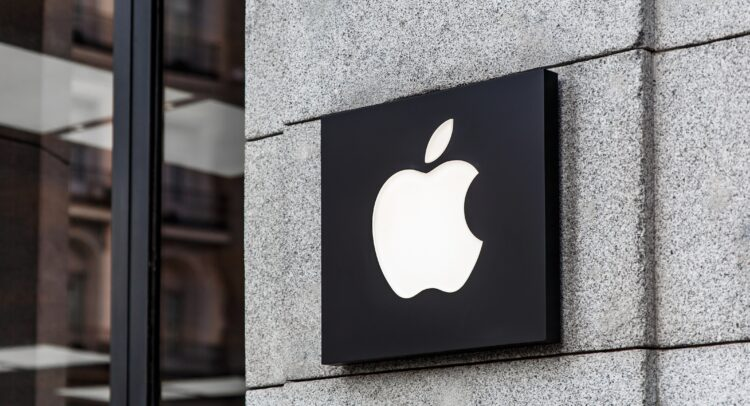

#### Context
In this project, we will study the stock AAPL (the ticker symbol for Apple Inc.). We will use the yfinance API to fetch a dataset of AAPL's historical stock prices over a period of time. This data is typically used for financial analysis, including studying trends in the stock price, predicting future prices, or analyzing the volatility of the stock.
</br></br>

#### Content
- Date: The specific date of the stock prices listed.
- Open: The price at which Apple's stock opened on that particular day.
- High: The highest price Apple’s stock reached during that day.
-Low: The lowest price Apple’s stock reached during that day.
- Close: The price at which Apple's stock closed on that day.
- Adj Close: The adjusted closing price, which reflects the stock's closing price after adjustments for any actions such as dividends or stock splits.
- Volume: The number of shares traded on that particular day.
</br></br>

We will use this dataset to perform analyses with Prophet and ARIMA/SARIMA models to predict future close prices.

In [33]:
# !pip install prophet
# !pip install yfinance
# !pip install pmdarima
# !pip install tabulate
# !pip install plotly

In [34]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Import and read time series data

In [65]:
# Downloading stock data for AAPL (Apple Inc.) over the past 5 years
# You can replace the ticker "AAPL" with another ticker symbol (e.g., "GOOGL" for Alphabet) 
# Find the list of stocks here : https://finance.yahoo.com/markets/stocks/most-active/
end = pd.to_datetime("today").date()
start = end - pd.DateOffset(years=5)
df = yf.download("AAPL", start=start, end=end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-24,4.40250,4.43225,4.27750,4.31325,4.292372,317268000
2019-09-25,4.31275,4.47550,4.26775,4.45575,4.434182,308432000
2019-09-26,4.44600,4.45475,4.38225,4.43350,4.412041,234564000
2019-09-27,4.39150,4.44250,4.23300,4.29400,4.273216,362056000
2019-09-30,4.32000,4.36200,4.28850,4.35175,4.330686,186184000


In [36]:
df.shape

(1259, 6)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-09-24 to 2024-09-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


## Data visualization

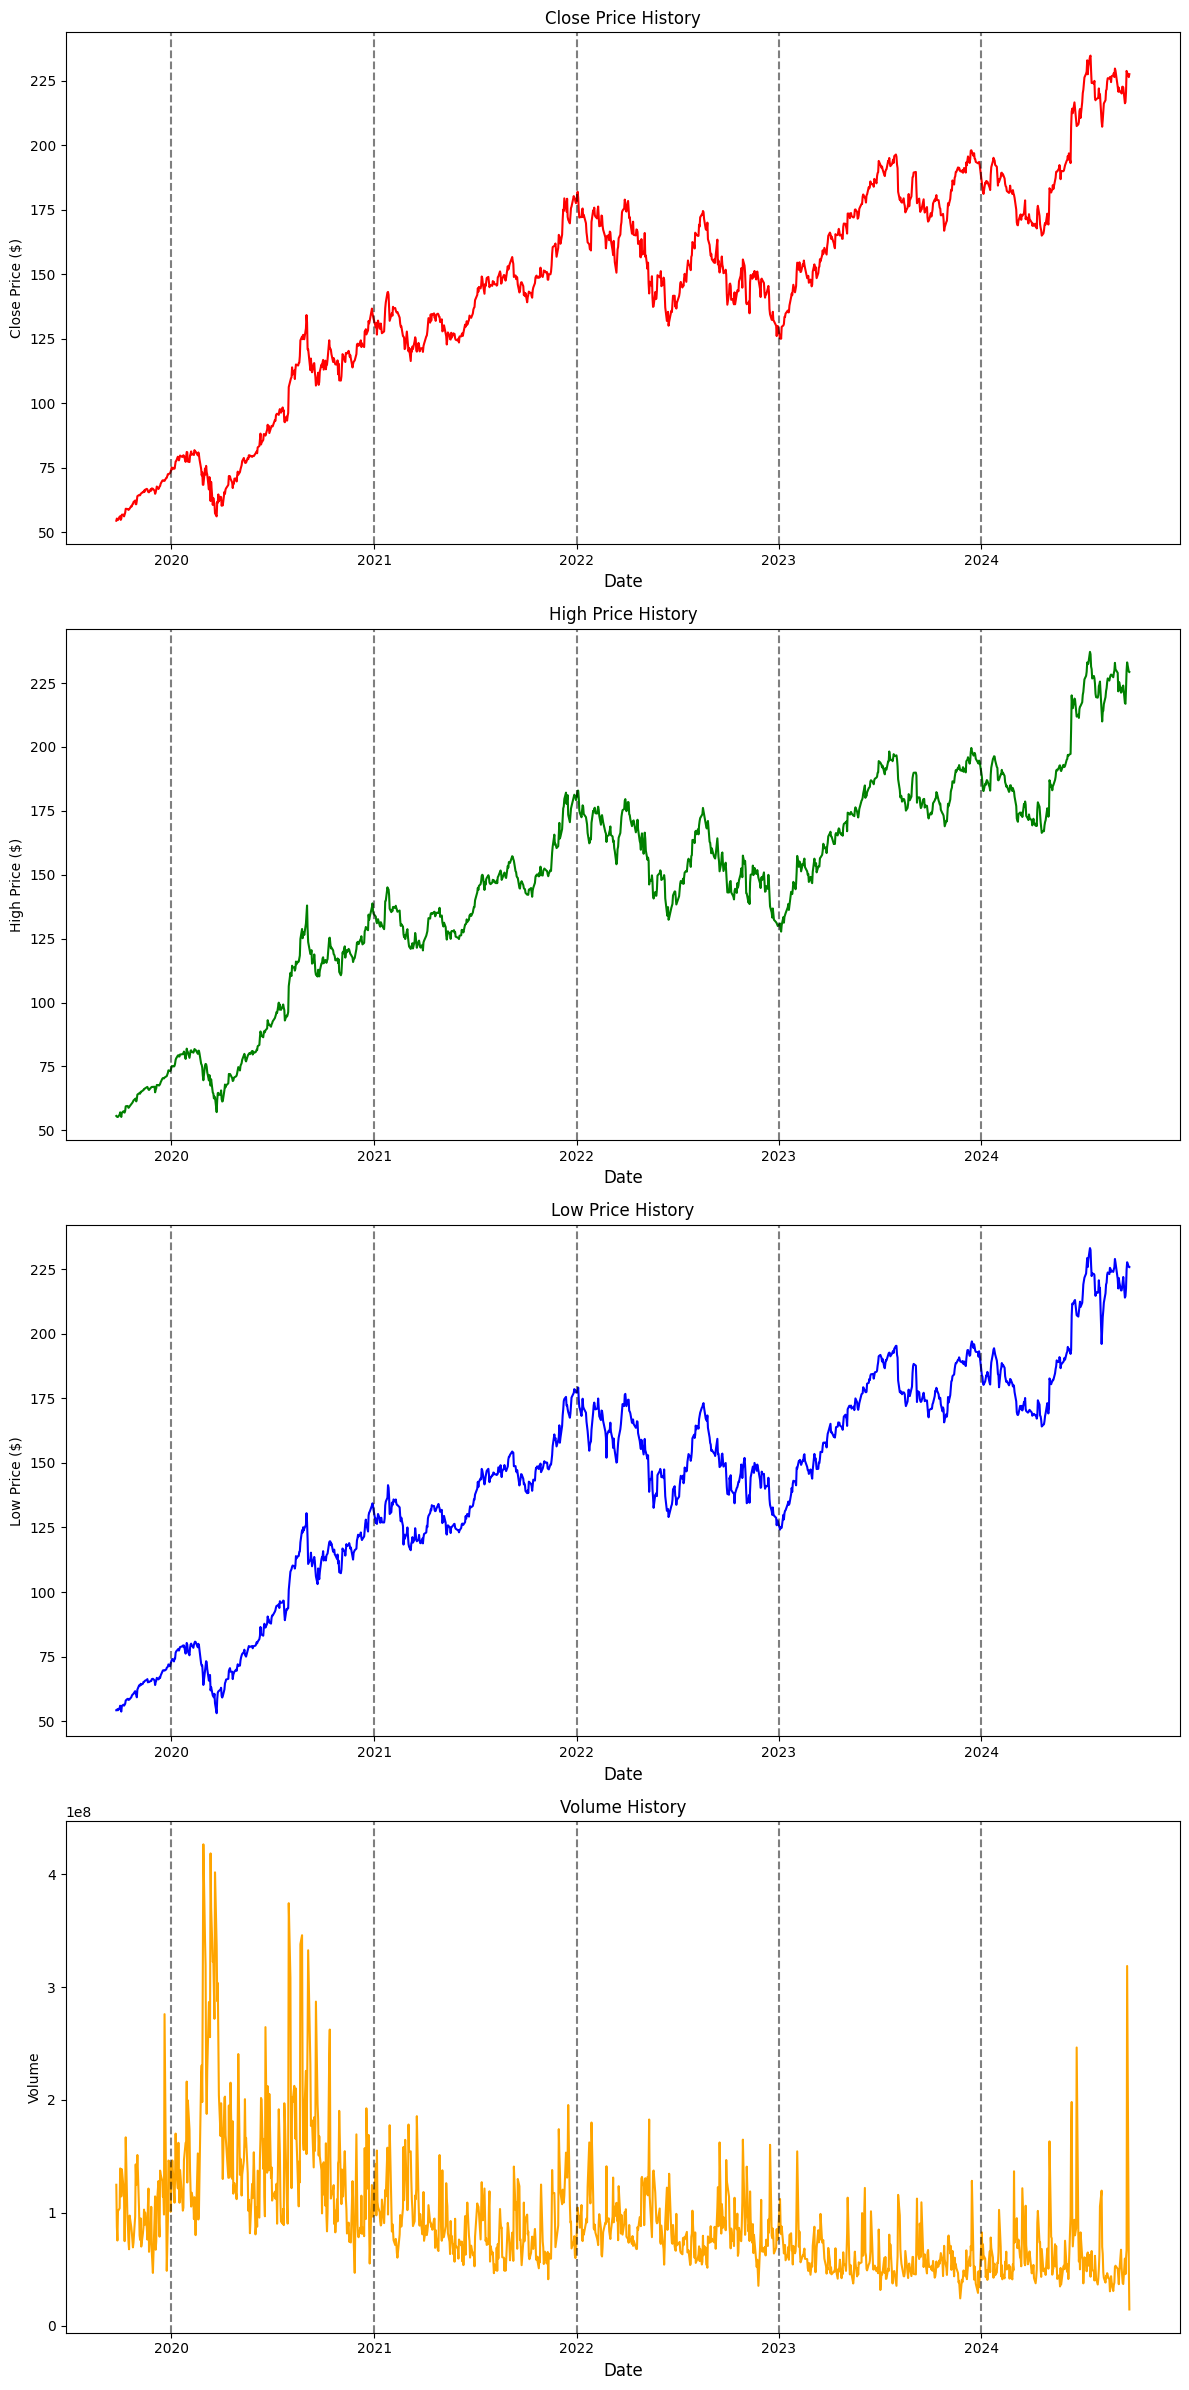

In [38]:
# Create the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))

# Close Price Plot
ax1.plot(df.index, df["Close"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price ($)")
ax1.set_title("Close Price History")

# High Price Plot
ax2.plot(df.index, df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("High Price ($)")
ax2.set_title("High Price History")

# Low Price Plot
ax3.plot(df.index, df["Low"], color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Low Price ($)")
ax3.set_title("Low Price History")

# Volume Plot
ax4.plot(df.index, df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("Volume History")

# Add vertical lines for each year in all plots
xcoords = pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS')
for xc in xcoords:
    ax1.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=xc, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Long-term Trends

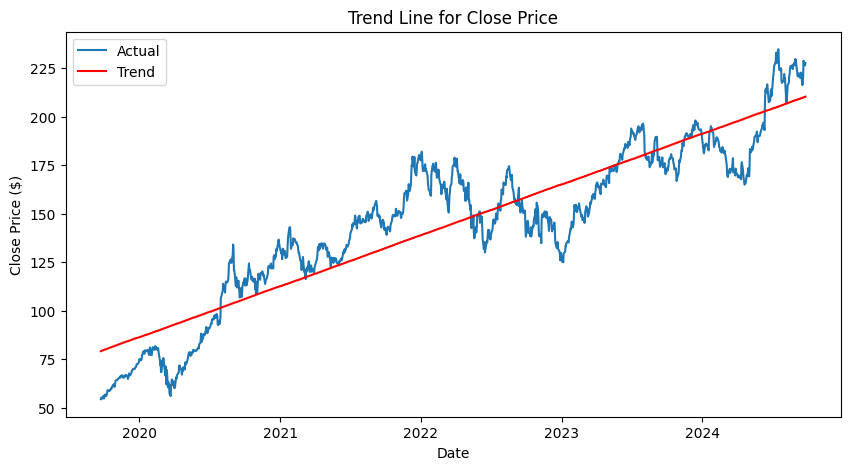

In [39]:
# Linear Regression for Trend Analysis
X = np.arange(len(df)).reshape(-1, 1)  # Time as an independent variable
y = df['Close'].values  # Close price as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the actual data and the trend line together
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, trend, label='Trend', color='red')
plt.title('Trend Line for Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

## Data Preprocessing
We're likely focusing on analyzing and predicting the "Close" price of the AAPL stock, which represents the final price at which the stock was traded during a particular day. Hence, the other columns—Open, High, Low, Volume, and Adj Close—will be dropped because they are not directly relevant to this specific analysis.

In [40]:
df2 = df[['Close']]
df2.head()

,Close
Date,
2019-09-24,54.419998
2019-09-25,55.257500
2019-09-26,54.972500
2019-09-27,54.705002
2019-09-30,55.992500


## Time decomposition

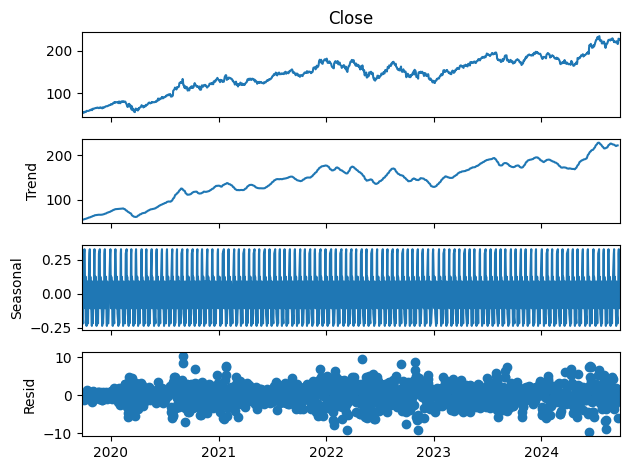

In [41]:
results = seasonal_decompose(df2['Close'], model='additive', period=12)
results.plot()
plt.show()

## Check stationarity

In [42]:
df_diff = df2.dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                             |
|---------------|-----------------------------------|
| ADF Statistic | -1.2949173101424067               |
| P-value       | 0.6314944304407932                |
| Conclusion    | The time series is not stationary |


In [43]:
from pmdarima.arima.utils import ndiffs
d_value = ndiffs(df2,test = "adf")
print("d value:", d_value)

d value: 1


In [44]:
df_diff = df2.diff().dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                         |
|---------------|-------------------------------|
| ADF Statistic | -36.00554872503358            |
| P-value       | 0.0                           |
| Conclusion    | The time series is stationary |


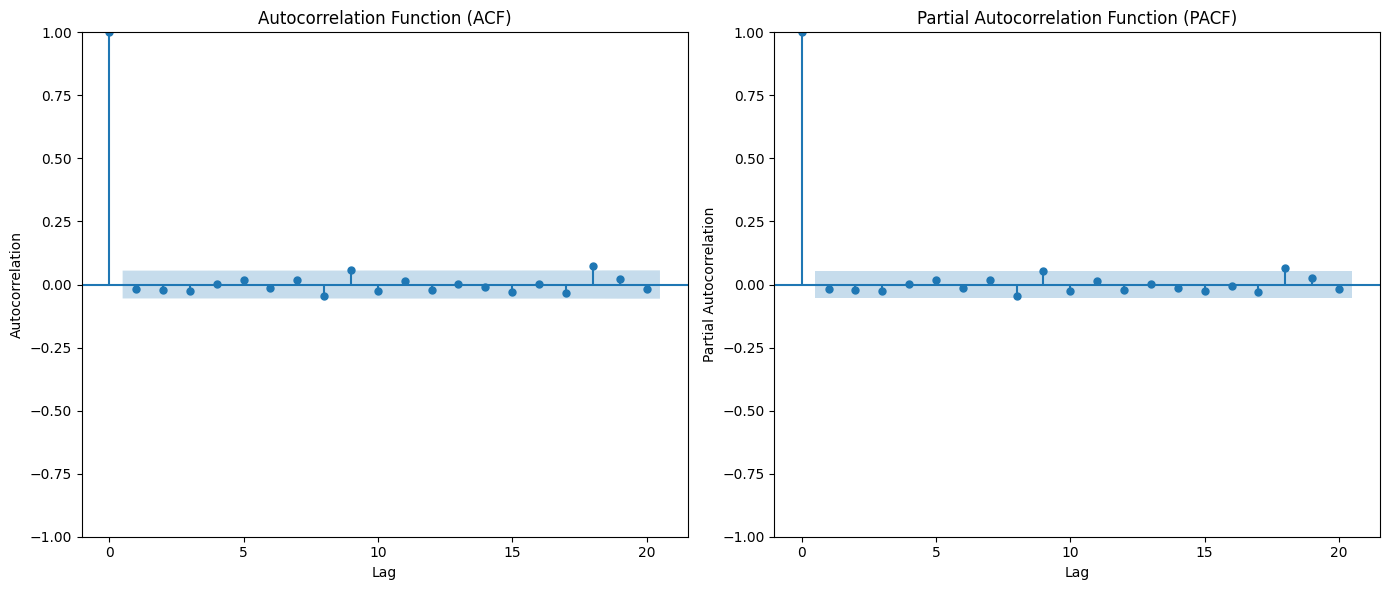

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns

# Plot ACF
plot_acf(df2.Close.diff().dropna(), lags=20, ax=ax[0])  # ACF on the left
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df2.Close.diff().dropna(), lags=20, ax=ax[1])  # PACF on the right
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Train / Test Split

In [46]:
split_index = int(len(df2) * 0.8)
df_train = df2.iloc[:split_index]
df_test = df2.iloc[split_index:]
print(len(df_train),len(df_test))

1007 252


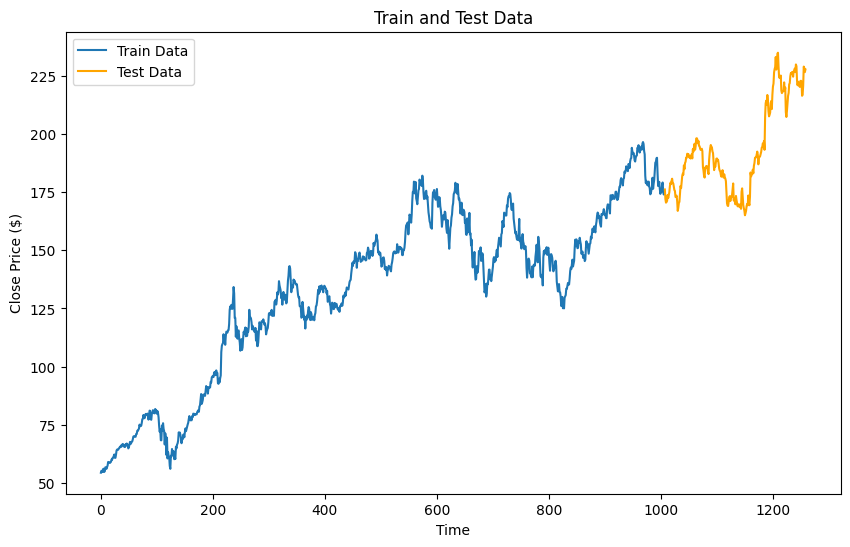

In [47]:
plt.figure(figsize=(10, 6))

# Plot x_train
plt.plot(range(len(df_train)), df_train, label='Train Data')

# Plot x_test
plt.plot(range(len(df_train), len(df_train) + len(df_test)), df_test, label='Test Data', color='orange')

plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.title('Train and Test Data')
plt.legend()

plt.show()

## ARIMA

#### Define orders automatically

In [48]:
stepwise_fit = auto_arima(df2,trace=True,suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6015.398, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6011.247, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6012.914, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6012.898, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6012.677, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6014.070, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.350 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3003.623
Date:                Tue, 24 Sep 2024   AIC                           6011.247
Time:                        18:18:31   BIC                           6021.521
Sample:                             0   HQIC                          6015.108
          

#### Plot residuals

(array([0.00867466, 0.12022346, 0.02406913, 0.00073307, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00012218]),
 array([-10.72766725,  -4.2266678 ,   2.27433166,   8.77533111,
         15.27633056,  21.77733001,  28.27832946,  34.77932891,
         41.28032836,  47.78132781,  54.28232726]),
 <BarContainer object of 10 artists>)

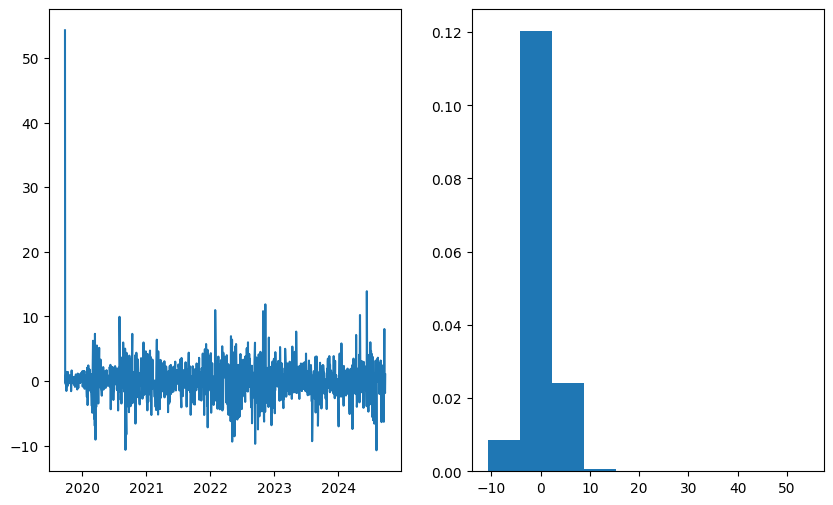

In [49]:
# Get the residuals from the fitted model
residuals = pd.DataFrame(stepwise_fit.arima_res_.resid, columns=['Residuals'])

# Create a subplot with 2 plots :  residuals over time and histogral of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot residuals over time to check for any patterns or trends
ax1.plot(residuals)
ax2.hist(residuals, density=True)

#### Make prediction

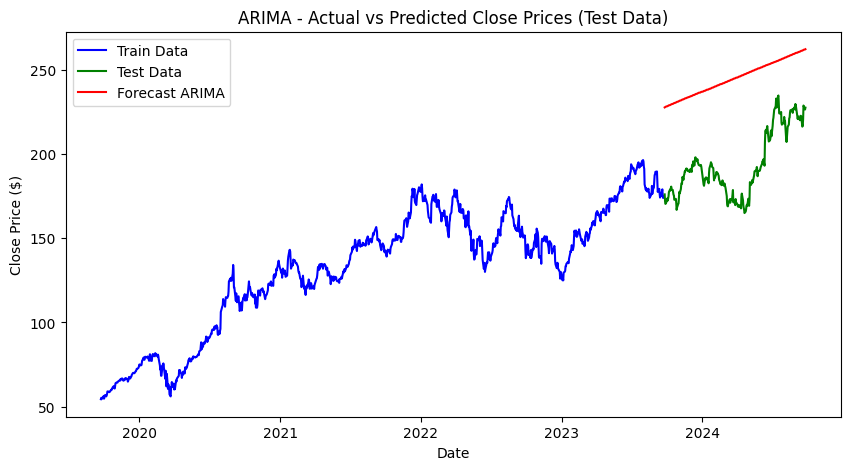

In [50]:
# Predict values for the test dataset
pred_arima = stepwise_fit.predict(n_periods=len(df_test))

df_fct = df2.copy()
df_fct['fct_arima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_arima'] = pred_arima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')

plt.title('ARIMA - Actual vs Predicted Close Prices (Test Data)')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the ARIMA Model (rolling cross validation)

In [51]:
# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
mae_arima_list = []
mape_arima_list = []
rmse_arima_list = []

# Rolling cross-validation
for train_index, test_index in tscv.split(df2):
    # Split the data into rolling train and test sets
    train, test = df2.iloc[train_index], df2.iloc[test_index]
    
    # Make predictions on the test set
    predictions = stepwise_fit.predict(n_periods=len(test))
    
    # Calculate performance metrics
    mae_arima = mean_absolute_error(test, predictions)
    mape_arima = mean_absolute_percentage_error(test, predictions) * 100  # In percentage
    rmse_arima = np.sqrt(mean_squared_error(test, predictions))
    
    # Append metrics to the respective lists
    mae_arima_list.append(mae_arima)
    mape_arima_list.append(mape_arima)
    rmse_arima_list.append(rmse_arima)

# Calculate average performance metrics across all folds
avg_mae_arima = np.mean(mae_arima_list)
avg_mape_arima = np.mean(mape_arima_list)
avg_rmse_arima = np.mean(rmse_arima_list)

# Print the average metrics
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [avg_mae_arima, f'{avg_mape_arima:.2f}%', avg_rmse_arima]
})
print(performance.set_index('Metrics'))


             ARIMA
Metrics           
MAE      82.706867
MAPE        56.49%
RMSE     83.844178


## SARIMA

#### Define orders automatically

In [52]:
from pmdarima import auto_arima
smodel = auto_arima(
                    df2,
                    seasonal=True, 
                    m=7,
                    max_p=7, 
                    max_d=1, 
                    max_q=3, 
                    max_P=3, 
                    max_D=1, 
                    max_Q=2,
                    trace=True,
                    error_action='ignore',    # To print the progress of the fitting
                    suppress_warnings=True,   # Ignore potential errors
                    sn_jobs=-1)               # Use all available CPU cores
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6011.247, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6014.582, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6014.561, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6012.677, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=6012.875, Time=0.18 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=6012.869, Time=0.15 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=6014.805, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=6012.914, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=6012.898, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=6014.070, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 5.762 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3003.623
Date:                Tue, 24 Sep 2024   AIC                           6011.247
Time:                        18:18:38   BIC                           6021.521
Sample:                             0   HQIC                          6015.108
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1377      0.074      1.853      0.064      -0.008       0.283
sigma2         6.9404      0.187     37.027      0.000       6.573       7.308
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               291.83
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.01
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot residuals

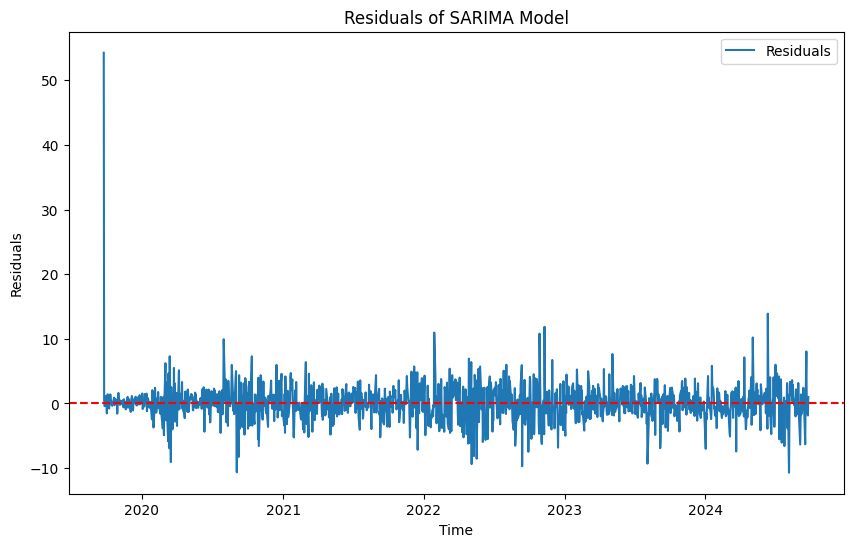

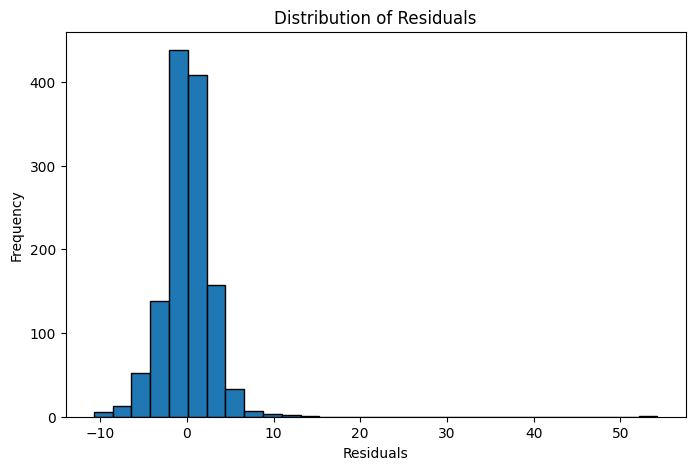

In [53]:
# Get the residuals from the fitted SARIMA model
residuals = smodel.resid()

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Optional: Plot the histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


#### Make predictions

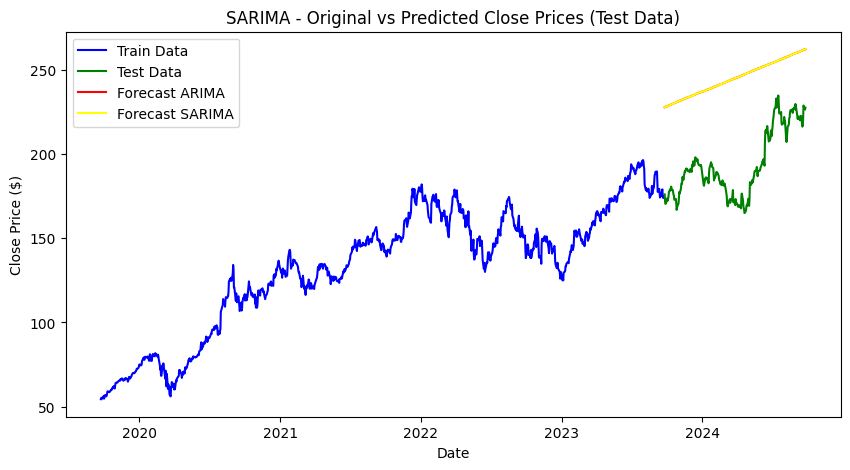

In [54]:
# Make predictions for the test dataset
predictions_sarima = smodel.predict(n_periods=len(df_test))

df_fct['fct_sarima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_sarima'] = predictions_sarima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='yellow')


plt.title('SARIMA - Original vs Predicted Close Prices (Test Data)')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the SARIMA Vs ARIMA (rolling cross validation)

In [55]:
# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
mae_sarima_list = []
mape_sarima_list = []
rmse_sarima_list = []

# Rolling cross-validation
for train_index, test_index in tscv.split(df2):
    # Split the data into rolling train and test sets
    train, test = df2.iloc[train_index], df2.iloc[test_index]
    
    # Make predictions on the test set
    predictions = smodel.predict(n_periods=len(test))
    
    # Calculate performance metrics
    mae_sarima = mean_absolute_error(test, predictions)
    mape_sarima = mean_absolute_percentage_error(test, predictions) * 100  # In percentage
    rmse_sarima = np.sqrt(mean_squared_error(test, predictions))
    
    # Append metrics to the respective lists
    mae_sarima_list.append(mae_sarima)
    mape_sarima_list.append(mape_sarima)
    rmse_sarima_list.append(rmse_sarima)

# Calculate average performance metrics across all folds
avg_mae_sarima = np.mean(mae_sarima_list)
avg_mape_sarima = np.mean(mape_sarima_list)
avg_rmse_sarima = np.mean(rmse_sarima_list)

# Print the average metrics
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [avg_mae_arima, f'{avg_mape_arima:.2f}%', avg_rmse_arima],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima]
})
print(performance.set_index('Metrics'))


             ARIMA     SARIMA
Metrics                      
MAE      82.706867  82.706867
MAPE        56.49%     56.49%
RMSE     83.844178  83.844178


Since both ARIMA and SARIMA give exactly the same performance metrics, it means that seasonality isn't playing a significant role in this particular dataset. 

## Prophet

In [56]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_train_prophet.head()

,ds,y
0,2019-09-24,54.419998
1,2019-09-25,55.257500
2,2019-09-26,54.972500
3,2019-09-27,54.705002
4,2019-09-30,55.992500


##### Fit

In [57]:
%%time
m_prophet = Prophet()
m_prophet.fit(df_train_prophet)

18:18:39 - cmdstanpy - INFO - Chain [1] start processing
18:18:39 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 125 ms
Wall time: 468 ms


##### Generate predictions

In [58]:
fct_prophet = m_prophet.predict(df_test_prophet)
fct_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-25,189.764422,177.509244,195.931783,189.764422,189.764422,-2.610384,-2.610384,-2.610384,1.258916,1.258916,1.258916,-3.869299,-3.869299,-3.869299,0.0,0.0,0.0,187.154039
1,2023-09-26,189.931436,177.852214,196.368850,189.931436,189.931436,-2.994269,-2.994269,-2.994269,1.056263,1.056263,1.056263,-4.050532,-4.050532,-4.050532,0.0,0.0,0.0,186.937167
2,2023-09-27,190.098449,177.996187,196.021238,190.098449,190.098449,-3.063884,-3.063884,-3.063884,1.123182,1.123182,1.123182,-4.187066,-4.187066,-4.187066,0.0,0.0,0.0,187.034565
3,2023-09-28,190.265462,178.421178,195.968209,190.265462,190.265462,-3.331368,-3.331368,-3.331368,0.948661,0.948661,0.948661,-4.280029,-4.280029,-4.280029,0.0,0.0,0.0,186.934094
4,2023-09-29,190.432476,177.443115,196.106445,190.432476,190.432476,-3.428498,-3.428498,-3.428498,0.902622,0.902622,0.902622,-4.331120,-4.331120,-4.331120,0.0,0.0,0.0,187.003978


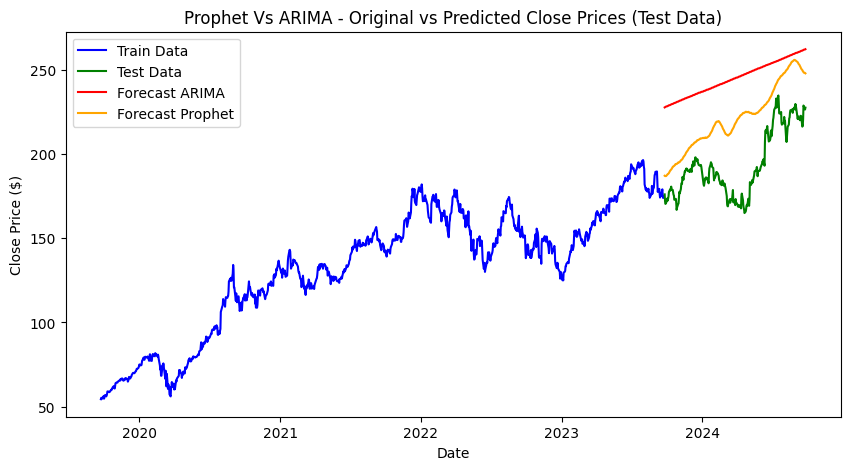

In [59]:
df_fct['fct_prophet'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_prophet'] = fct_prophet['yhat'].values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_prophet'], label='Forecast Prophet', color='orange')

plt.title('Prophet Vs ARIMA - Original vs Predicted Close Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

#### Evaluate the prophet model (cross validation)

In [60]:
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.head()

,ds,Open,High,Low,y,Adj Close,Volume
0,2019-09-24,55.257500,55.622501,54.297501,54.419998,52.659180,124763200
1,2019-09-25,54.637501,55.375000,54.285000,55.257500,53.469593,87613600
2,2019-09-26,55.000000,55.235001,54.707500,54.972500,53.193810,75334000
3,2019-09-27,55.134998,55.240002,54.320000,54.705002,52.934971,101408000
4,2019-09-30,55.224998,56.145000,55.197498,55.992500,54.180805,103909600


In [61]:
m = Prophet().fit(df_prophet)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:43 - cmdstanpy - INFO - Chain [1] done processing
18:18:43 - cmdstanpy - INFO - Chain [1] start processing
18:18:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-10-06,143.366087,138.973328,147.825563,142.000000,2021-10-05
1,2021-10-07,143.435188,139.097961,147.865203,143.289993,2021-10-05
2,2021-10-08,143.490009,139.443916,147.756327,142.899994,2021-10-05
3,2021-10-11,143.931770,139.862428,148.248618,142.809998,2021-10-05
4,2021-10-12,144.053912,139.852820,148.449738,141.509995,2021-10-05


## Comparison of metrics - ARIMA vs Prophet models

In [62]:
mae_prophet = mean_absolute_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])
mape_prophet = mean_absolute_percentage_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])*100
rmse_prophet = np.sqrt(mean_squared_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [avg_mae_arima, f'{avg_mape_arima:.2f}%', avg_rmse_arima],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
})

print(performance.set_index('Metrics'))

             ARIMA    Prophet
Metrics                      
MAE      82.706867  37.596576
MAPE        56.49%     22.65%
RMSE     83.844178  44.249449


#### ✨ The more effective model is the one with the lower MAPE : Prophet ✨

## 2-Year forecast using the best model

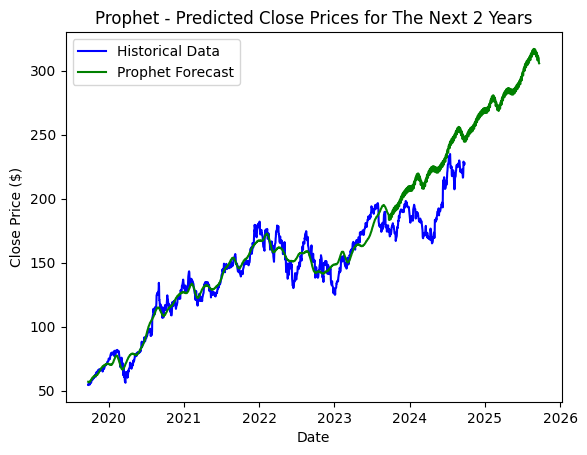

In [63]:
year = 2
steps = year * 365   # Number of steps to forecast (daily data)
df = df.reset_index() # Reset index

# Create future dataframe and predict
future_prophet = m_prophet.make_future_dataframe(periods=steps, freq='D')
prophet_forecast = m_prophet.predict(future_prophet)

# Plot
plt.plot(df2.index, df2['Close'], label='Historical Data', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='green')

plt.title(f"Prophet - Predicted Close Prices for The Next {year} Years")
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()